# 保持器の頂点とエッジと面のインデックスのリストをXMLで出力

事前に流れとして，以下のことを実行しておいてください．

1. CADモデルをCATIA上で作成する．.igsファイルに出力．
2. STAR-CCM+ で .igsファイルから流体モデルの作成．メッシングまで行う．
3. メッシュデータを .CGNS ファイルに出力する．
4. ParaVIEWで.vtmファイルにし，子フォルダにある.vtuファイルを更にASCII形式で保存し直す．

最終的にこのノートブックは，各エッジ・フェイスのインデックスをテキストで出力します．それを元にこの後Rustで複数条件のMorphedメッシュを出力する（予定），となります．

In [122]:
import numpy as np
from matplotlib import pyplot as plt
import pyvista as pv


In [123]:
# ファイル名を指定してデータを読み込む
# mesh = pv.read('../data/Tetra_Cage.vtu')
full_mesh = pv.read('../data/Tetra.vtu')
# full_mesh = pv.read('../data/Tetra_linspace.vtu')
# full_mesh.points[:,0] *= -1
# full_mesh.points[:,1] *= -1
full_points = np.array(full_mesh.points.tolist()) 
full_points.shape


(7431, 3)

In [124]:
# Extract the surface of the full_mesh
surface = full_mesh.extract_surface()

# Get the points from the surface
surface_points = surface.points

# Print the shape of the surface points array
print(surface_points.shape)


(3792, 3)


In [125]:
tetras = full_mesh.cells.reshape(-1, 5)[:,1:]
tetras[:5], tetras.shape

(array([[ 0,  2,  1,  3],
        [ 6,  5,  7,  4],
        [ 7,  5,  6,  8],
        [ 1,  2,  0,  9],
        [ 7,  4,  5, 10]]),
 (35054, 4))

In [126]:
from collections import Counter
counter = Counter(tuple(t) for t in tetras)
duplicates = {t: count for t, count in counter.items() if count > 1}

print(duplicates)


{}


In [127]:
# Parameters

Rp = 0.825e-3
xp = [0, 2.65e-3, 2.00e-3] # y成分だけ？
Ri = 2.345e-3
Ro = 2.85e-3
hz = 2.45e-3
dhz = 0.152e-3
Rb = 0.778e-3
xb = [0, 2.645e-3, 2.00e-3]
# Rb = 2.54e-3 * 5 / 16

xsh = [0, 2.65e-3, 2.00e-3 - 0.30e-3]
Rsh = 1.2e-3

hsh = 2.10e-3
lsh = 0.93e-3
bevel = 0.10e-3

ratio = 0.355 # 目測で測った値

In [128]:
2.54e-3 * 5 / 16

0.0007937500000000001

In [129]:
dhz * (1-ratio) + 0.295e-3
dhz * 0.55 + 0.765e-3

0.0008485999999999999

In [130]:
Rapt = np.sqrt(Rp**2 - (hz - dhz - xp[2])**2)
Rapt


0.0007692990315865477

In [131]:
not_ball = np.linalg.norm(surface_points - xp, axis=1) > Rp * 0.95

not_ball_points = surface_points[not_ball]
not_ball_points.shape

(3007, 3)

In [132]:
z_dist = np.linalg.norm(not_ball_points[:,:2], axis=1)


In [133]:
is_cage = (z_dist > Ri * 0.99) & (z_dist < Ro * 1.01) & (not_ball_points[:,2] < hz * 1.01) & (not_ball_points[:,2] > lsh * 0.99)
cage_points = not_ball_points[is_cage]


In [134]:
azimath = np.rad2deg(np.arctan2(cage_points[:,0], cage_points[:,1])) 

is_wall = ((azimath < (-30 * 0.99)) | (azimath > (30 * 0.99))) & (cage_points[:,2] > (hsh * 1.01))
points = cage_points[~is_wall]


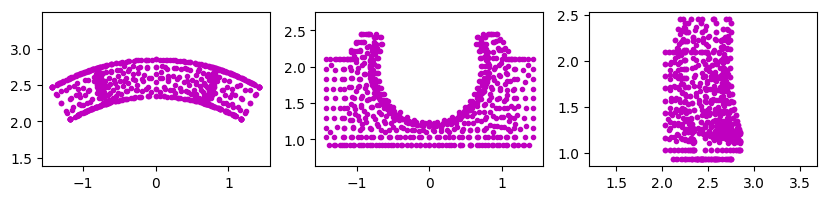

In [135]:
fig, ax = plt.subplots(1, 3, figsize=(10, 2))
for i in[0,1]:
    ax[i].plot(points[:,0]*1e3, points[:,1+i]*1e3, 'm.')
    ax[i].axis('equal')
ax[2].plot(points[:,1]*1e3, points[:,2]*1e3, 'm.')
ax[2].axis('equal')
plt.show()


## 面単位で点のリストを取得する

In [136]:
z_distance = np.linalg.norm(points[:,0:2], axis=1)


In [137]:
curvature_in = points[z_distance < Ri*1.001]
curvature_out = points[z_distance > Ro*0.999]

curvature_in.shape, curvature_out.shape

((189, 3), (214, 3))

In [138]:
sphire = points[np.linalg.norm(points - xp, axis=1) < Rp*1.0001]
sphire.shape

(227, 3)

In [139]:
shoulder = points[(points[:,2] > hsh*0.999)&(points[:,2] < hsh*1.001)]
shoulder_left = shoulder[shoulder[:,0] < -Rp]
shoulder_right = shoulder[shoulder[:,0] > Rp]

shoulder.shape, shoulder_left.shape, shoulder_right.shape

((30, 3), (15, 3), (15, 3))

In [140]:
sh_dist = np.linalg.norm(points - xsh, axis=1)
neck = points[(sh_dist < Rsh*1.01)&(sh_dist > Rsh*0.99)&(points[:,2] > hsh*0.999)]
sphire_left = neck[neck[:,0] < -0]
sphire_right = neck[neck[:,0] > 0]

neck.shape, sphire_left.shape, sphire_right.shape


((40, 3), (20, 3), (20, 3))

In [141]:
top = points[points[:,2] > hz*0.999]
top_left = top[top[:,0] < -0]
top_right = top[top[:,0] > 0]

top.shape, top_left.shape, top_right.shape


((18, 3), (9, 3), (9, 3))

In [142]:
bottom = points[points[:,2] < lsh*1.001]
bottom.shape

(68, 3)

In [143]:
get_cone = lambda x,y: points[(x<(y*1.001)) & (x>(y*0.999))]

cone_in = get_cone(z_distance + points[:,2], Ri+lsh+bevel)
cone_in.shape


(46, 3)

In [144]:
# cone_out = points[(-z_distance + points[:,2])<(lsh-Ro+bevel)*0.999]
cone_out = get_cone(z_distance - points[:,2], Ro-lsh-bevel)
cone_out.shape


(46, 3)

In [145]:
azimath = np.rad2deg(np.arctan2(points[:,1], points[:,0]))
end_left = points[(azimath > 120*0.999)]
end_right = points[(azimath < 60*1.001)]

end_left.shape, end_right.shape


((24, 3), (24, 3))

In [146]:
z_apt = np.linalg.norm(points[:,:2] - xp[:2], axis=1)

straw = points[(z_apt < Rapt*1.005)&(points[:,2] > hsh)]
straw_left = straw[straw[:,0] < 0]
straw_right = straw[straw[:,0] > 0]

straw.shape, straw_left.shape, straw_right.shape


((20, 3), (10, 3), (10, 3))

In [147]:
apature = points[((points[:,2] - z_apt) > (hz - Rapt - dhz * ratio)*0.97)&(points[:,2] > hsh)]
apature_left = apature[apature[:,0] < 0]
apature_right = apature[apature[:,0] > 0]

apature.shape, apature_left.shape, apature_right.shape


((18, 3), (9, 3), (9, 3))

In [148]:
face_list = [
    'bottom', 'top_left', 'top_right', 'end_left', 'end_right',
    'cone_in', 'cone_out', 'curvature_in', 'curvature_out',
    'shoulder_left', 'shoulder_right',
    'sphire_left', 'sphire_right',
    'straw_left', 'straw_right',
    'apature_left', 'apature_right',
    'sphire',
]
if len(face_list) != len(set(face_list)):
    print("Duplicate elements found in the face list.")
else:
    print("No duplicate elements found in the face list.")


len(face_list)

No duplicate elements found in the face list.


18

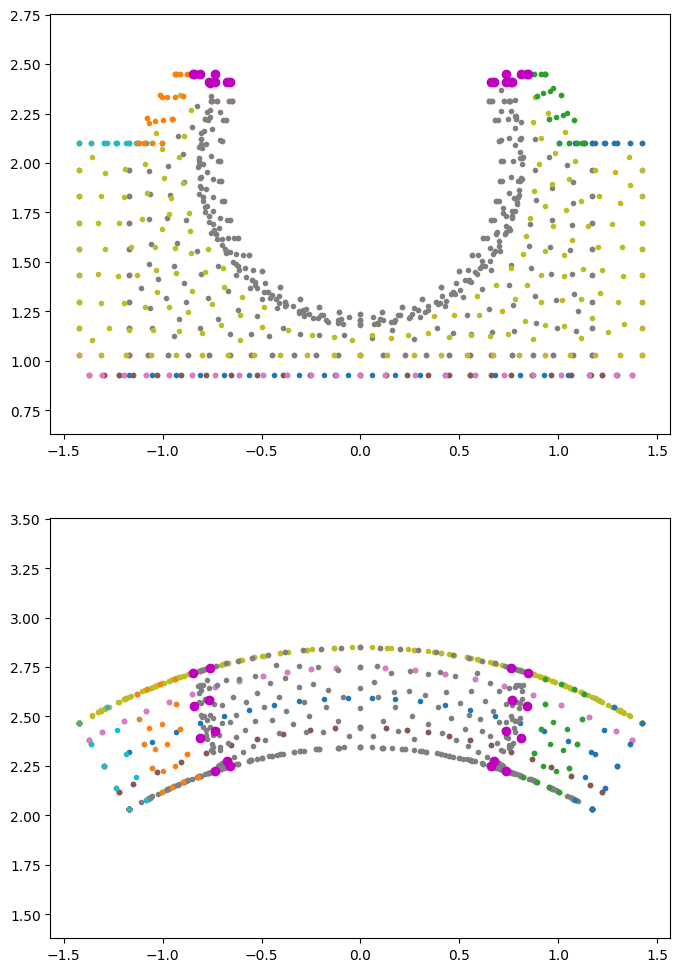

In [149]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12))
plot_key = lambda key, i, style='.': ax[i].plot(key[:,0]*1e3, key[:,2-i]*1e3, style)

for i in[0,1]:
    for key in face_list:
        plot_key(eval(key), i)
        # if 'apature' in key:
        #     plot_key(eval(key), i, 'ro')
    for key in face_list:
        if 'apature' in key:
            plot_key(eval(key), i, 'mo')
    ax[i].axis('equal')


## 面同士の共通点からエッジのリストを出す

In [150]:
import pandas as pd

def common_points(point0, point1):
    df0 = pd.DataFrame(point0, columns=['x', 'y', 'z'])
    df1 = pd.DataFrame(point1, columns=['x', 'y', 'z'])
    common_points = pd.merge(df0, df1, left_on=['x', 'y', 'z'], right_on=['x', 'y', 'z'], indicator=False)
    return common_points.to_numpy()


In [151]:
curve_bottom_in = common_points(bottom, cone_in)#
curve_bottom_out = common_points(bottom, cone_out)#
curve_in_bottom = common_points(cone_in, curvature_in)#
curve_out_bottom = common_points(cone_out, curvature_out)#

curve_bottom_in.shape, curve_bottom_out.shape, curve_in_bottom.shape, curve_out_bottom.shape

((23, 3), (23, 3), (23, 3), (23, 3))

In [152]:
curve_in_top_left = common_points(curvature_in, shoulder_left)#
curve_in_top_right = common_points(curvature_in, shoulder_right)#
curve_out_top_left = common_points(curvature_out, shoulder_left)#
curve_out_top_right = common_points(curvature_out, shoulder_right)#

curve_in_top_left.shape, curve_in_top_right.shape, curve_out_top_left.shape, curve_out_top_right.shape


((3, 3), (3, 3), (3, 3), (3, 3))

In [153]:
curve_top_in_left = common_points(curvature_in, top_left)#
curve_top_in_right = common_points(curvature_in, top_right)#
curve_top_out_left = common_points(curvature_out, top_left)#
curve_top_out_right = common_points(curvature_out, top_right)#

curve_top_in_left.shape, curve_top_in_right.shape, curve_top_out_left.shape, curve_top_out_right.shape

((2, 3), (2, 3), (2, 3), (2, 3))

In [154]:
collar_middle_left = common_points(apature_left, straw_left)#
collar_middle_right = common_points(apature_right, straw_right)#

collar_middle_left.shape, collar_middle_right.shape


((5, 3), (5, 3))

In [155]:
straight_left_bottom = common_points(bottom, end_left)#
straight_right_bottom = common_points(bottom, end_right)#

straight_left_bottom.shape, straight_right_bottom.shape


((3, 3), (3, 3))

In [156]:
straight_in_left = common_points(curvature_in, end_left)#
straight_in_right = common_points(curvature_in, end_right)#
straight_out_left = common_points(curvature_out, end_left)#
straight_out_right = common_points(curvature_out, end_right)#

straight_in_left.shape, straight_in_right.shape, straight_out_left.shape, straight_out_right.shape

((9, 3), (9, 3), (9, 3), (9, 3))

In [157]:
straight_top_left = common_points(end_left, shoulder_left)#
straight_top_right = common_points(end_right, shoulder_right)#

straight_top_left.shape, straight_top_right.shape


((5, 3), (5, 3))

In [158]:
slope_bottom_left_in = common_points(cone_in, end_left)#
slope_bottom_right_in = common_points(cone_in, end_right)#
slope_bottom_left_out = common_points(cone_out, end_left)#
slope_bottom_right_out = common_points(cone_out, end_right)#

slope_bottom_left_in.shape, slope_bottom_right_in.shape, slope_bottom_left_out.shape, slope_bottom_right_out.shape

((2, 3), (2, 3), (2, 3), (2, 3))

In [159]:
slope_in_top_left = common_points(apature_left, curvature_in)#
slope_in_top_right = common_points(apature_right, curvature_in)#
slope_out_top_left = common_points(apature_left, curvature_out)#
slope_out_top_right = common_points(apature_right, curvature_out)#

slope_in_top_left.shape, slope_in_top_right.shape, slope_out_top_left.shape, slope_out_top_right.shape

((2, 3), (2, 3), (2, 3), (2, 3))

In [160]:
collar_left_out = common_points(shoulder_left, sphire_left)#
collar_right_out = common_points(shoulder_right, sphire_right)#

collar_left_out.shape, collar_right_out.shape


((5, 3), (5, 3))

In [161]:
collar_left_middle = common_points(sphire_left, top_left)#
collar_right_middle = common_points(sphire_right, top_right)#
collar_left_in = common_points(apature_left, top_left)#
collar_right_in = common_points(apature_right, top_right)#

collar_left_middle.shape, collar_right_middle.shape, collar_left_in.shape, collar_right_in.shape

((5, 3), (5, 3), (4, 3), (4, 3))

In [162]:
collar_bottom_left = common_points(sphire, straw_left)#
collar_bottom_right = common_points(sphire, straw_right)#

collar_bottom_left.shape, collar_bottom_right.shape


((5, 3), (5, 3))

In [163]:
ellipse_in_center = common_points(sphire, curvature_in)#
ellipse_in_left = common_points(curvature_in, sphire_left)#
ellipse_in_right = common_points(curvature_in, sphire_right)#
ellipse_out_center = common_points(sphire, curvature_out)#
ellipse_out_left = common_points(curvature_out, sphire_left)#
ellipse_out_right = common_points(curvature_out, sphire_right)#

ellipse_in_center.shape, ellipse_in_left.shape, ellipse_in_right.shape, ellipse_out_center.shape, ellipse_out_left.shape, ellipse_out_right.shape


((29, 3), (4, 3), (4, 3), (33, 3), (4, 3), (4, 3))

In [164]:
stripe_in_left = common_points(straw_left, curvature_in)#
stripe_in_right = common_points(straw_right, curvature_in)#
stripe_out_left = common_points(straw_left, curvature_out)#
stripe_out_right = common_points(straw_right, curvature_out)#

stripe_in_left.shape, stripe_in_right.shape, stripe_out_left.shape, stripe_out_right.shape


((2, 3), (2, 3), (2, 3), (2, 3))

In [165]:
edge_list = [
    'curve_bottom_in', 'curve_bottom_out', 'curve_in_bottom', 'curve_out_bottom', 'curve_in_top_left', 'curve_in_top_right', 'curve_out_top_left', 'curve_out_top_right', 'curve_top_in_left', 'curve_top_in_right', 'curve_top_out_left', 'curve_top_out_right',  
    'straight_left_bottom', 'straight_right_bottom', 'straight_in_left', 'straight_in_right', 'straight_out_left', 'straight_out_right', 'straight_top_left', 'straight_top_right', 
    'slope_bottom_left_in', 'slope_bottom_right_in', 'slope_bottom_left_out', 'slope_bottom_right_out', 'slope_in_top_left', 'slope_in_top_right', 'slope_out_top_left', 'slope_out_top_right', 
    'collar_left_out', 'collar_right_out', 
    'collar_left_middle', 'collar_right_middle', 'collar_left_in', 'collar_right_in', 'collar_bottom_left', 'collar_bottom_right', 'collar_middle_left', 'collar_middle_right',
    'ellipse_in_center', 'ellipse_in_left', 'ellipse_in_right', 'ellipse_out_center', 'ellipse_out_left', 'ellipse_out_right', 
    'stripe_in_left', 'stripe_in_right', 'stripe_out_left', 'stripe_out_right', 
]
if len(edge_list) != len(set(edge_list)):
    print("Duplicate elements found in the edge list.")
else:
    print("No duplicate elements found in the edge list.")

len(edge_list), sum(eval(edge).size for edge in edge_list) // 3

No duplicate elements found in the edge list.


(48, 314)

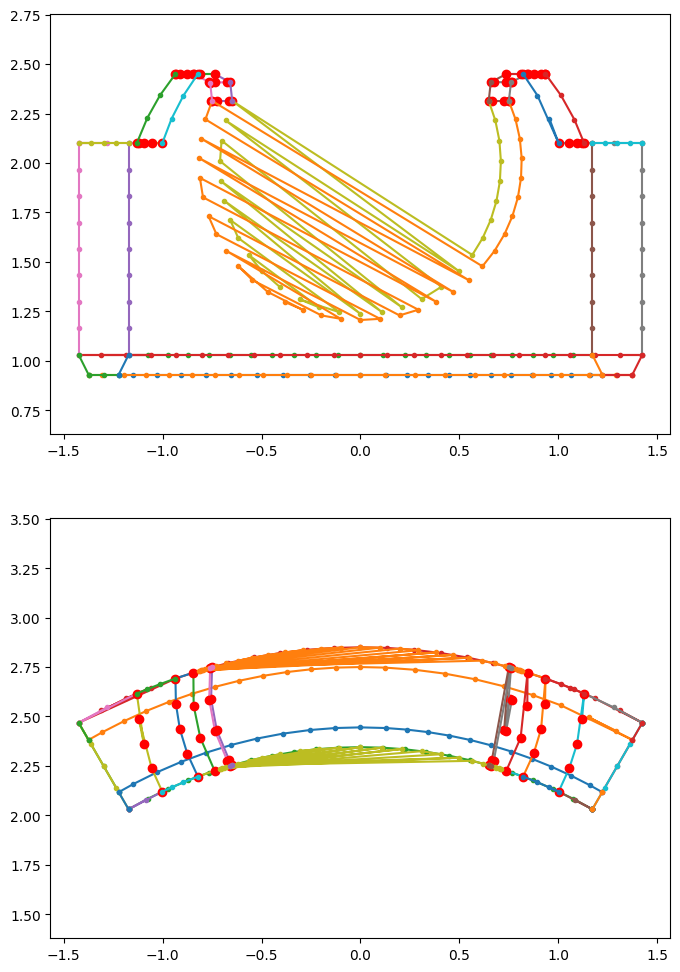

In [166]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12))

for i in[0,1]:
    for key in edge_list:
        plot_key(eval(key), i, style='.-')
        if 'collar' in key:
            plot_key(eval(key), i, 'ro')
    ax[i].axis('equal')


## エッジの並びを代数的に与える

この際，重複する点はあってもいいとする．できるなら，二重以上で定義される点は，それらが一致していることを確認する．以下の2つの作業を各エッジに対して行う．

1. エッジの座標の並びを綺麗に整列するように決める．
2. フルモデルからエッジの座標を使って対応するインデックスを取得する．
3. 


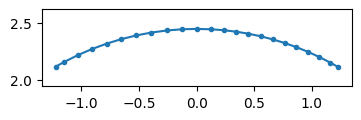

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(4, 1))
plt.plot(eval(edge_list[0])[:,0]*1e3, eval(edge_list[0])[:,1]*1e3, '.-')
plt.axis('equal')
plt.show()

In [168]:
def calculate_distances_and_find_best_axis(points):
    distances = points.max(axis=0) - points.min(axis=0)
    best_axis = np.argmax(distances)
    max_distance = distances[best_axis]
    return max_distance, best_axis

def sort_by_best_axis(points):
    _, best_axis = calculate_distances_and_find_best_axis(points)
    sorted_indices = np.argsort(points[:, best_axis])
    return points[sorted_indices]

def sort_by_azimath(points):
    azimath = np.arctan2(points[:,0] - xp[0], -points[:,2] + xp[2])
    sorted_indices = np.argsort(azimath)
    return points[sorted_indices]



In [169]:
sorted_edge_list = []

for edge in edge_list:
    edge_sorted = edge + '_sorted'

    is_ellipse = (edge.startswith('ellipse')) and (edge.endswith('center'))
    globals()[edge_sorted] = sort_by_azimath(eval(edge)) if is_ellipse else sort_by_best_axis(eval(edge))
    
    sorted_edge_list.append(edge_sorted)
    print(edge_sorted, eval(edge_sorted).shape)


curve_bottom_in_sorted (23, 3)
curve_bottom_out_sorted (23, 3)
curve_in_bottom_sorted (23, 3)
curve_out_bottom_sorted (23, 3)
curve_in_top_left_sorted (3, 3)
curve_in_top_right_sorted (3, 3)
curve_out_top_left_sorted (3, 3)
curve_out_top_right_sorted (3, 3)
curve_top_in_left_sorted (2, 3)
curve_top_in_right_sorted (2, 3)
curve_top_out_left_sorted (2, 3)
curve_top_out_right_sorted (2, 3)
straight_left_bottom_sorted (3, 3)
straight_right_bottom_sorted (3, 3)
straight_in_left_sorted (9, 3)
straight_in_right_sorted (9, 3)
straight_out_left_sorted (9, 3)
straight_out_right_sorted (9, 3)
straight_top_left_sorted (5, 3)
straight_top_right_sorted (5, 3)
slope_bottom_left_in_sorted (2, 3)
slope_bottom_right_in_sorted (2, 3)
slope_bottom_left_out_sorted (2, 3)
slope_bottom_right_out_sorted (2, 3)
slope_in_top_left_sorted (2, 3)
slope_in_top_right_sorted (2, 3)
slope_out_top_left_sorted (2, 3)
slope_out_top_right_sorted (2, 3)
collar_left_out_sorted (5, 3)
collar_right_out_sorted (5, 3)
collar_le

collar_left_out_sorted
collar_right_out_sorted
collar_left_middle_sorted
collar_right_middle_sorted
collar_left_in_sorted
collar_right_in_sorted
collar_bottom_left_sorted
collar_bottom_right_sorted
collar_middle_left_sorted
collar_middle_right_sorted
collar_left_out_sorted
collar_right_out_sorted
collar_left_middle_sorted
collar_right_middle_sorted
collar_left_in_sorted
collar_right_in_sorted
collar_bottom_left_sorted
collar_bottom_right_sorted
collar_middle_left_sorted
collar_middle_right_sorted


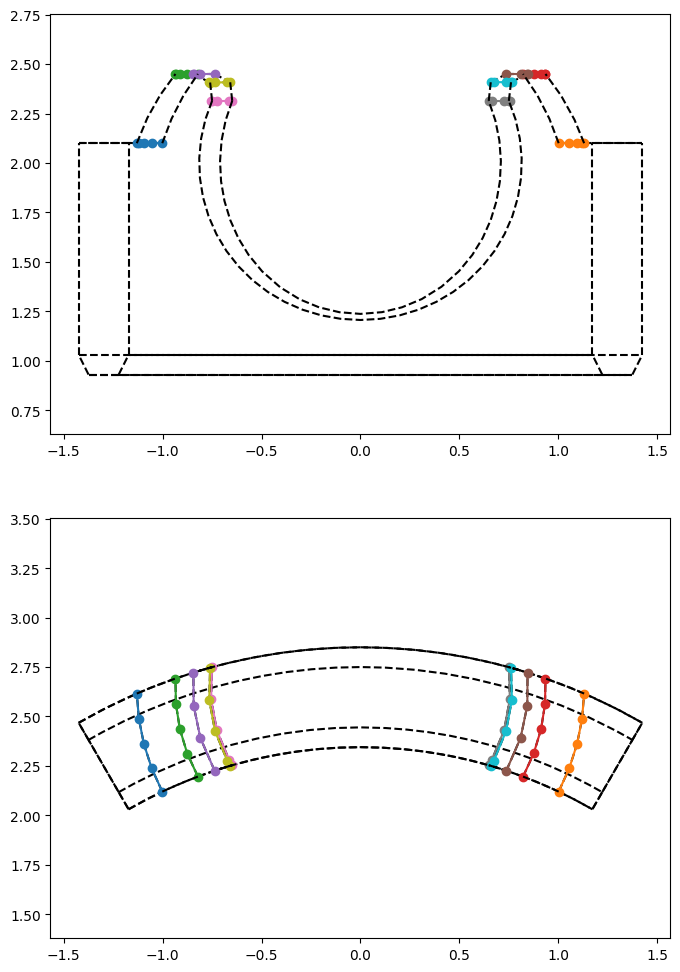

In [170]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12))

for i in[0,1]:
    for key in sorted_edge_list:
        plot_key(eval(key), i, style='k--')
        if ('collar_' in key): # & ('top' in key):
            print(key)
            plot_key(eval(key), i, style='o-')

    ax[i].axis('equal')


## 面からエッジを取り除く

In [171]:
def complement_points(point0, point1, ev = True):
    df0 = pd.DataFrame(point0, columns=['x', 'y', 'z'])
    for p in point1:
        df1 = pd.DataFrame(eval(p) if ev else p, columns=['x', 'y', 'z'])
        df0  = df0[~df0[['x', 'y', 'z']].apply(tuple, 1).isin(df1[['x', 'y', 'z']].apply(tuple, 1))]
    return df0.to_numpy()

complement_points_by_edge = lambda points: complement_points(points, edge_list)


In [172]:
compl_face_list = []

for face in face_list:
    name_complement = face + '_compl'
    globals()[name_complement] = complement_points_by_edge(eval(face))
    compl_face_list.append(name_complement)
    print(name_complement, eval(name_complement).shape)

len(compl_face_list), sum(eval(compl_face).shape[0] for compl_face in compl_face_list)

bottom_compl (20, 3)
top_left_compl (0, 3)
top_right_compl (0, 3)
end_left_compl (0, 3)
end_right_compl (0, 3)
cone_in_compl (0, 3)
cone_out_compl (0, 3)
curvature_in_compl (107, 3)
curvature_out_compl (128, 3)
shoulder_left_compl (3, 3)
shoulder_right_compl (3, 3)
sphire_left_compl (6, 3)
sphire_right_compl (6, 3)
straw_left_compl (0, 3)
straw_right_compl (0, 3)
apature_left_compl (0, 3)
apature_right_compl (0, 3)
sphire_compl (159, 3)


(18, 432)

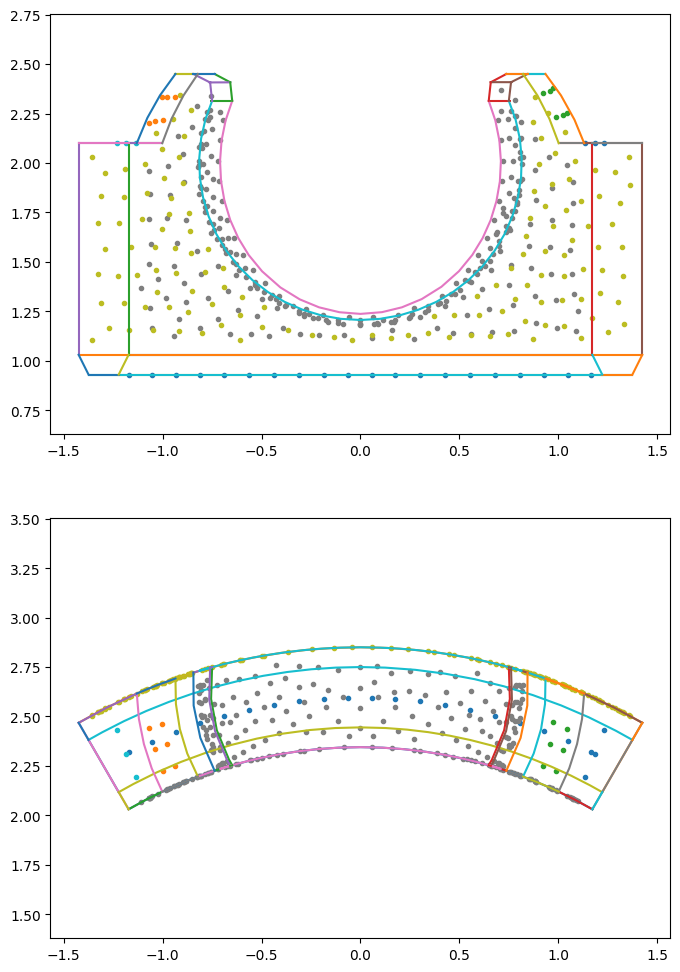

In [173]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12))

for i in[0,1]:
    for key in compl_face_list:
        if True: # "sphire" in key:
            plot_key(eval(key), i, style='.')
    for key in sorted_edge_list:
        plot_key(eval(key), i, style='-')
    ax[i].axis('equal')


## 周期境界条件部分のインデックス

In [174]:
azimath_all = np.rad2deg(np.arctan2(full_points[:,0], full_points[:,1])) 
is_wall_all = ((azimath_all < (-30 * 0.99)) | (azimath_all > (30 * 0.99)))
wall_indices = np.where(is_wall_all)[0]
wall_indices.shape, wall_indices.min(), wall_indices.max()


((685,), 0, 7430)

In [175]:
tetra_count = np.isin(tetras, wall_indices)
tetra_count, tetra_count.shape

(array([[ True, False,  True,  True],
        [ True,  True, False,  True],
        [False,  True,  True,  True],
        ...,
        [False, False, False,  True],
        [ True,  True, False, False],
        [False,  True,  True,  True]]),
 (35054, 4))

In [176]:
is_face = tetra_count.sum(axis=1) > 2
surface_tetras = tetras[is_face]
surface_tetras, surface_tetras.shape


(array([[   0,    2,    1,    3],
        [   6,    5,    7,    4],
        [   7,    5,    6,    8],
        ...,
        [7423, 7426, 7418, 7427],
        [7426, 7427, 7423, 7429],
        [7428, 7429, 7427, 7430]]),
 (1158, 4))

In [177]:
tetra_count = np.isin(surface_tetras, wall_indices)
surface_triangles = surface_tetras[tetra_count].reshape(-1, 3)
surface_triangles, surface_triangles.shape

(array([[   0,    1,    3],
        [   6,    5,    4],
        [   5,    6,    8],
        ...,
        [7426, 7418, 7427],
        [7426, 7427, 7429],
        [7429, 7427, 7430]]),
 (1158, 3))

In [178]:
from collections import Counter
from itertools import combinations

# 各トライアングルから2つの要素の全ての組み合わせを生成
index_pairs = [tuple(sorted(pair)) for triangle in surface_triangles for pair in combinations(triangle, 2)]

# 各ペアの出現回数をカウント
counter = Counter(index_pairs)

# 1回しか登場しないペアを探す
unique_pairs = [pair for pair, count in counter.items() if count == 1]

# 結果を表示
print(unique_pairs)

[(0, 3), (1, 3), (4, 6), (6, 8), (1, 4), (8, 26), (0, 30), (37, 39), (36, 39), (26, 53), (30, 62), (37, 72), (53, 77), (77, 79), (62, 88), (72, 122), (36, 124), (79, 126), (124, 126), (88, 186), (122, 229), (186, 261), (229, 354), (261, 399), (399, 579), (354, 590), (579, 785), (590, 800), (785, 871), (800, 882), (871, 1061), (1061, 1179), (882, 1202), (1258, 1259), (1258, 1262), (1377, 1378), (1259, 1387), (1387, 1390), (1390, 1392), (1262, 1377), (1179, 1560), (1202, 1586), (1498, 1643), (1498, 1644), (1378, 1648), (1648, 1664), (1392, 1666), (1560, 1703), (1429, 1714), (1664, 1781), (1643, 1784), (1703, 1838), (1781, 1784), (1644, 1899), (1429, 1958), (1838, 2070), (1714, 2079), (1586, 1976), (1666, 2135), (1958, 2187), (2070, 2190), (1899, 2242), (2190, 2308), (2079, 2315), (1976, 2430), (2135, 2475), (2308, 2517), (2315, 2523), (2242, 2567), (2187, 2623), (2430, 2643), (2643, 2739), (2475, 2767), (2517, 2814), (2623, 2815), (2567, 2850), (2814, 2910), (2523, 2912), (2739, 3018), (

In [179]:
# 全てのペアをフラットなリストに変換
flat_list = [item for sublist in unique_pairs for item in sublist]

# ユニークな要素のみを取得
edge_indices = np.unique(flat_list)
edge_indices[:10]

array([ 0,  1,  3,  4,  6,  8, 26, 30, 36, 37])

In [180]:
wall_indices = np.array(list(set(wall_indices) - set(edge_indices)))
wall_indices[:10]

array([6144, 6147,    5,    9,   12,   17, 4114, 2068, 2069,   22])

In [181]:
(azimath_all[wall_indices] < 0).shape

(473,)

In [182]:
periodic_left_compl = full_points[wall_indices[azimath_all[wall_indices] > 0]]
periodic_right_compl = full_points[wall_indices[azimath_all[wall_indices] < 0]]

periodic_left_compl.shape, periodic_right_compl.shape

((237, 3), (236, 3))

In [183]:
compl_face_list.append('periodic_left_compl')
compl_face_list.append('periodic_right_compl')

In [184]:
on_ball = surface_points[np.linalg.norm(surface_points - xb, axis=1) < Rb * 1.02]

on_ball.shape, common_points(sphire, on_ball)

((785, 3), array([], shape=(0, 3), dtype=float64))

In [185]:
# compl_face_list.append('on_ball_compl')

## フルモデルからindexを抽出する

In [186]:
def get_index_in_fullmodel(full_points, points):
    df0 = pd.DataFrame(full_points, columns=['x', 'y', 'z'])
    df1 = pd.DataFrame(points, columns=['x', 'y', 'z'])
    df0['idx'] = df0.index
    df1 = df1.merge(df0, how='left', on=['x', 'y', 'z'])
    return df1['idx'].to_numpy()

get_index_in_fullmodel(full_points, eval(sorted_edge_list[0]))


array([7276, 7275, 7251, 7239, 7199, 7156, 7101, 7029, 6942, 6723, 6565,
       6367, 6160, 6007, 5859, 5583, 5396, 5304, 5115, 4920, 4612, 4278,
       4277])

### 球表面の，境界の狭間にあるメッシュ上の点とそうでない点のリストを作成する

In [190]:
sphire.shape

(227, 3)

In [193]:
from collections import defaultdict

# surface_index = get_index_in_fullmodel(full_points, surface_points)
surface_index = get_index_in_fullmodel(full_points, sphire)
ball_index    = get_index_in_fullmodel(full_points, on_ball)

ball_map = []

for index in tetras:
    bool_on_surface = np.array([i in surface_index for i in index])
    bool_on_ball    = np.array([i in ball_index for i in index])
    if (sum(bool_on_surface) == 3) & (sum(bool_on_ball) == 1):
        ball_map.append([index[bool_on_ball][0], index[~bool_on_ball]])

ball_dict = defaultdict(list)
for i in range(len(ball_map)):
    ball_dict[ball_map[i][0]].append(ball_map[i][1])

ball_map = [[k, v] for k, v in ball_dict.items() if len(v) > 1]
ball_map = [[k, np.concatenate(v)] for k, v in ball_map]
ball_map = [[k, np.unique(v)] for k, v in ball_map]
len(ball_map), ball_map


(135,
 [[1718, array([1580, 1847, 1851, 1969])],
  [1971, array([1705, 1851, 2086, 2201])],
  [1951, array([1705, 1952, 2086, 2294])],
  [1970, array([1851, 1969, 2196, 2201])],
  [2195, array([1847, 2317, 2319, 2424])],
  [2318, array([1969, 2196, 2319, 2427, 2631])],
  [2320, array([2196, 2201, 2427, 2533, 2534])],
  [2321, array([2086, 2201, 2428, 2534])],
  [2295, array([2086, 2294, 2428, 2510])],
  [2425, array([2319, 2424, 2631, 2730])],
  [2617, array([2428, 2510, 2718, 2807])],
  [2628, array([2317, 2424, 2629, 2730, 2918])],
  [2632, array([2427, 2533, 2631, 2825])],
  [2731, array([2533, 2534, 2718, 2923, 2924])],
  [2899, array([2718, 2807, 2925, 3011, 3112])],
  [2826, array([2718, 2923, 2925, 3013])],
  [2922, array([2533, 2825, 2924, 3110])],
  [2919, array([2730, 2918, 2920, 3106])],
  [2921, array([2631, 2825, 2920, 3106, 3108])],
  [3012, array([2923, 2924, 3013, 3208, 3210])],
  [3111, array([2925, 3013, 3112, 3311])],
  [3205, array([3108, 3110, 3307, 3401, 3499, 350

In [194]:
ball_with_connect = np.array([k for k, _ in ball_map])
ball_without_connect = ball_index[~np.isin(ball_index, ball_with_connect)]

ball_with_connect.shape, ball_without_connect.shape, ball_index.shape


((135,), (650,), (785,))

In [195]:
compl_face_list.append('ball_compl')
ball_compl = full_points[ball_without_connect]

In [196]:
edge_indices = []

for edge in sorted_edge_list:
    edge_full = edge + '_full'
    globals()[edge_full] = get_index_in_fullmodel(full_points, eval(edge))
    edge_indices.append(edge_full)

sum(eval(edge).shape[0] for edge in edge_indices)

314

In [197]:
face_indices = []

for face in compl_face_list:
    face_full = face + '_full'
    globals()[face_full] = get_index_in_fullmodel(full_points, eval(face))
    print(face_full)
    face_indices.append(face_full)

sum(eval(face).shape[0] for face in face_indices)


bottom_compl_full
top_left_compl_full
top_right_compl_full
end_left_compl_full
end_right_compl_full
cone_in_compl_full
cone_out_compl_full
curvature_in_compl_full
curvature_out_compl_full
shoulder_left_compl_full
shoulder_right_compl_full
sphire_left_compl_full
sphire_right_compl_full
straw_left_compl_full
straw_right_compl_full
apature_left_compl_full
apature_right_compl_full
sphire_compl_full
periodic_left_compl_full
periodic_right_compl_full
ball_compl_full


1555

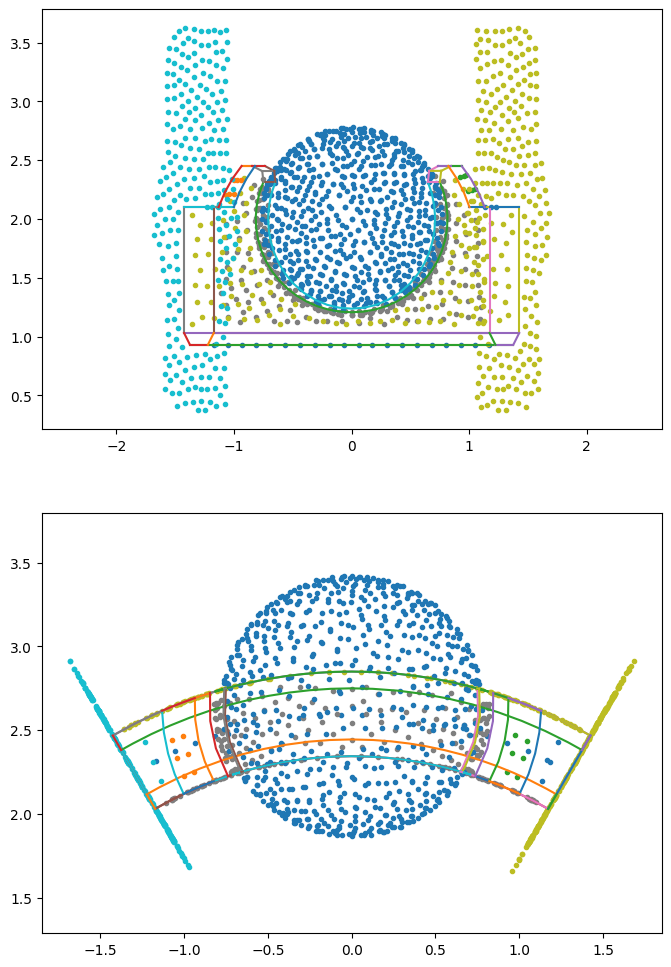

In [198]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12))

for i in[0,1]:
    for key in face_indices:
        plot_key(full_points[eval(key)], i, style='.')
    for key in edge_indices:
        plot_key(full_points[eval(key)], i, style='-')
    ax[i].axis('equal')


## xmlで書き出し

In [199]:
import xml.etree.ElementTree as ET
          
root = ET.Element("root")
root.text = '\n'
root.tail = '\n'

edge_root = ET.SubElement(root, "edge")
edge_root.text = '\n'
edge_root.tail = '\n'

for edge in edge_indices:
    section = ET.SubElement(edge_root, edge[:-12])
    section.text = '\n' + ' '.join(map(str, eval(edge).tolist())) + '\n'
    section.tail = '\n'

face_root = ET.SubElement(root, "face")
face_root.text = '\n'
face_root.tail = '\n'

for face in face_indices:
    section = ET.SubElement(face_root, face[:-11])
    section.text = '\n' + ' '.join(map(str, eval(face).tolist())) + '\n'
    section.tail = '\n'

map_root = ET.SubElement(root, "map")
map_root.text = '\n'
map_root.tail = '\n'

section = ET.SubElement(map_root, 'ball_map')
section.text = '\n'
section.text += '\n'.join(f'{k} {" ".join(map(str, v))}' for k, v in ball_map)
section.text += '\n'
section.tail = '\n'

xml_string = ET.tostring(root, encoding="utf-8").decode("utf-8")

# with open("../data/face_and_edge_index_cage.xml", "w") as file:
with open("../data/face_and_edge_index.xml", "w") as file:
    file.write(xml_string)
